In [15]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Helper Functions

In [16]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')


def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})



# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Data

In [17]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [18]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Data Analysis

## Narrowing the scope of our project

Our client is looking to purchase a home in the Miami-Dade county. We want to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value. These predictions will be mades using Time Series modeling.

### Looking at our Florida data

In [19]:
#Dataframe containing only zips from Miami-Dade County

miami_dade =  df[df['CountyName']=='Miami-Dade']

In [20]:
#Observing what our Miami-Dade dataset looks like

miami_dade

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
222,72488,33186,The Crossings,FL,Miami-Fort Lauderdale,Miami-Dade,223,120600.0,120500.0,120500.0,...,310600,311800,313700,314800,315300,317500,320700,322800,323900,324500
226,72350,33012,Hialeah,FL,Miami-Fort Lauderdale,Miami-Dade,227,118400.0,118500.0,118500.0,...,300300,302100,304500,306400,307200,308900,311400,314100,317500,320500
376,72460,33157,Village of Palmetto Bay,FL,Miami-Fort Lauderdale,Miami-Dade,377,106400.0,106600.0,106800.0,...,295600,298300,301600,304400,305900,307500,309700,312500,316400,319800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,72473,33170,Goulds,FL,Miami-Fort Lauderdale,Miami-Dade,8157,89500.0,89300.0,89000.0,...,247100,249700,252500,254300,254700,255800,257700,259300,261800,264400
8568,72484,33182,Tamiami,FL,Miami-Fort Lauderdale,Miami-Dade,8569,135800.0,136100.0,136300.0,...,358100,359700,361100,362100,361400,361200,362900,363500,362500,362000
10524,72461,33158,Village of Palmetto Bay,FL,Miami-Fort Lauderdale,Miami-Dade,10525,233800.0,234200.0,234500.0,...,621700,619900,618000,616500,616700,618200,618500,621900,629500,634900
10580,72495,33194,Tamiami,FL,Miami-Fort Lauderdale,Miami-Dade,10581,133200.0,132900.0,132700.0,...,319700,321900,324100,325500,325400,325700,327200,327800,327400,327000


## Number of ZipCodes for each City in Florida

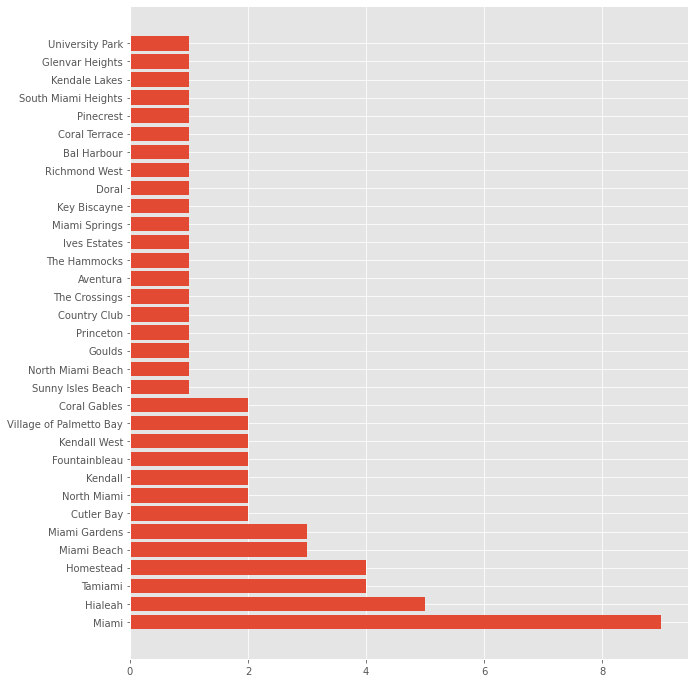

In [21]:
#Visualizing the value counts of zipcodes in each city in the Miami-Dade county

fig, ax = plt.subplots(figsize=(10,12))

y = [a for a in miami_dade['City'].value_counts()]

x = [a for a in miami_dade['City'].value_counts().keys()]

ax.barh(x,y);

We can see above that the city of Miami  has the highest number of zipcodes.

Our client has a budget of 300,000 Dollars so we want to help them purchase a property that has a price of 300,000 Dollars or less within the Miami-Dade County region.

In [22]:
miami_budget = miami_dade[miami_dade['2018-04']<=300000]

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Florida. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to find the zipcode that has seen the highest growth in the 3 years since our last recorded date - April, 2018. i.e. We will find the zipcode which has grown the most between April, 2015 and April, 2018.

In [23]:
#Creating a new column that shows the 5 year increase in value. From April, 2013 to April, 2018.
warnings.filterwarnings('ignore')

miami_budget['3_yr_ROI'] = None
miami_budget['3_yr_ROI'] = miami_budget['2018-04'].apply(lambda x : x-miami_budget['2015-04'])

In [24]:
#Identifying the ZipCode that grew the most between April,2013 and April,2018.

roi_df = miami_budget[['RegionName','3_yr_ROI']].sort_values('3_yr_ROI',ascending = False)

print(f'Highest growing Zipcode since April 2015 is : {int(roi_df.iloc[0][0])}')

Highest growing Zipcode since April 2015 is : 33126


We will run our first Time Series model on the ZipCode- 33126 to predict what its future value will be. Then we can run a similar model on other zipcodes in the state to identify which 5 zipcodes have the highest predicted ROI.

In [25]:
#Dataframe containining historical prices of the 33126 Zip Code.

zip33126 = df[df['RegionName']==33126]

In [26]:
# Time Series dataframe of 33126 Zip Code prices

series33126 = melt_data(zip33126)

In [27]:
#Observing our Time Series dataframe

series33126

,value
time,
1996-04-01,108600.0
1996-05-01,108800.0
1996-06-01,109100.0
1996-07-01,109400.0
1996-08-01,109700.0
...,...
2017-12-01,294300.0
2018-01-01,295700.0
2018-02-01,296900.0


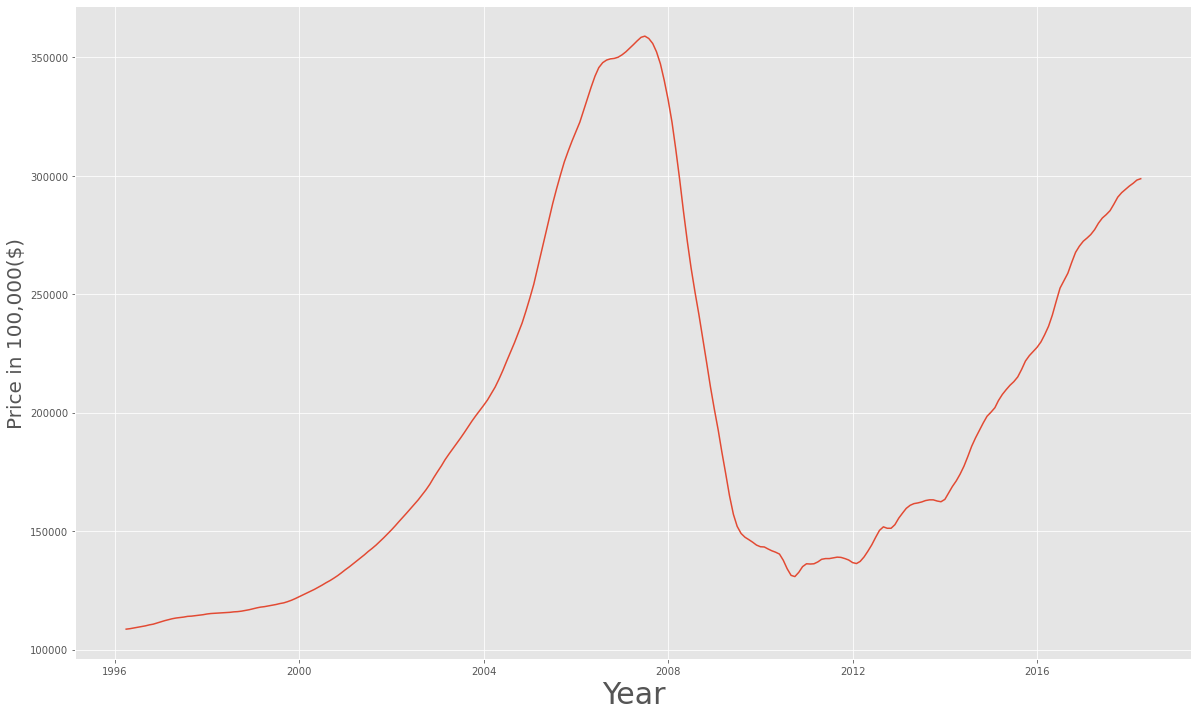

In [28]:
#Visualizing our Time Series Data for zipcode- 33126

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33126)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20);

We can see from above that after several years of growth in the early years of the 21st Century, prices seemed to have likely fallen due to the economic crisis that emerged in 2008. Since around 2011 though, there has been an increase in prices.

# Data Pre-Processing

## Tests for Stationarity

Time series models commonly operate with the assumption that the time series is **stationary**. i.e. Over a longer period of time, the series tends not to have a trend or seasonal effects. This means that if a time series that displays a particular behavior over time, it is highly likely that it will replicate similar behavior in the future. We can perform some tests for **Stationarity** to show if the time series is stationary.

### Looking at the Rolling Statistics

In [29]:
roll_mean = series33126.rolling(window=8, center=False).mean()
roll_std = series33126.rolling(window=8, center=False).std()

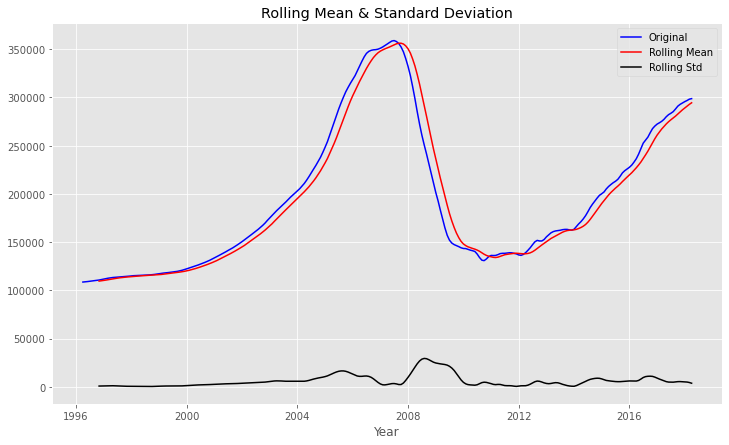

In [30]:
fig = plt.figure(figsize=(12,7))
plt.plot(series33126, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

We can see that our rolling mean increases over time. This means that our time series data is not stationary.

### The Dickey-Fuller Test

Let's perform a Dickey-Fuller test to prove statistically that the time series is not stationary. For the Dickey-Fuller test, the null hypothesis is that the time series is not stationary. Therefore, in order to reject the null hypothesis, we will want a p-value of less than 0.05.

In [31]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(series33126)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -2.525409
p-value                          0.109414
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


We can see from above that the test returned a p-value of 0.109414. This is higher than the 0.05 cutoff that was necessary to reject the null hypothesis. Therefore we fail to reject the null hypothesis and can conclude that the time series is not stationary. Of course this is quite intuitive just by looking at the graph, but it is always good practice to prove this statistically.

# Making our Time Series Stationary

As mentioned earlier, most models work under the assumption that the Time Series is stationary. Therefore we will need to make our current time series stationary. A common method that is used to eliminate this problem is **Differencing**.

## Differencing

Differencing is a common technique used to minimize the trend and seasonality in a non-stationary time series. In this method, we take the difference in values between a given instant and the instant that precedes it; thereby forming a 1-period lag.

In order to difference our time series, we will need to decide upon the best period value at which we want to do our differencing. Therefore we will perform a loop function to iterate over period values of 0 to 24 to find the smallest period that returns a p-value below 0.05.

In [32]:
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

def differencer(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

differencer(series33126)

0 nan
1 0.02943621148549072
2 0.019276188899760825
3 0.04488719582438247
4 0.05177661054162843
5 0.06548501168518119
6 0.2714644679621955
7 0.1750933653667825
8 0.17757026049253116
9 0.4895671801059798
10 0.17704758261677522
11 0.06651724013108871
12 0.031202099457968313
13 0.023110028350070977
14 0.07628608315075244
15 0.04137182024490709
16 0.07064367887391351
17 0.3058325813641038
18 0.45047699008758274
19 0.4066368659656263
20 0.44620283494744495
21 0.29948048012048545
22 0.19628490005264992
23 0.27927682839364687
24 0.2911661291599609


We can see from the above results that a period value of 12 is the smallest period that returns a p-value of less than 0.05. Therefore this is the period value we will use to perform differencing on our time series.

In [33]:
#We use .dropna() to remove the first 12 values which will return NaN.
series_diff= series33126.diff(periods=12).dropna()

Now that we have a differenced time series, let us perform our tests to check for stationarity.

# Testing our Differenced Series for Stationarity

### Differenced Time Series Rolling Statistics

In [34]:
roll_mean_diff = series_diff.rolling(window=8, center=False).mean()
roll_std_diff = series_diff.rolling(window=8, center=False).std()

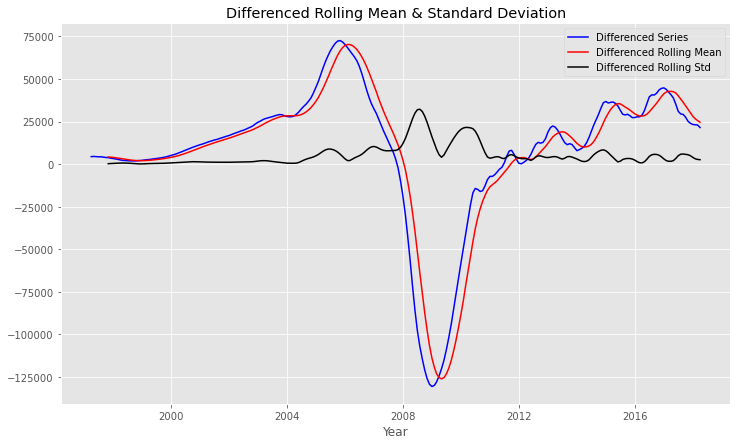

In [35]:
fig = plt.figure(figsize=(12,7))
plt.plot(series_diff, color='blue', label='Differenced Series')
plt.plot(roll_mean_diff, color='red', label='Differenced Rolling Mean')
plt.plot(roll_std_diff, color='black', label = 'Differenced Rolling Std')
plt.legend(loc='best')
plt.title('Differenced Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show(block=False)

There is a significant drop in the rolling mean of our differenced series during the financial crisis that occurred in 2008. But the rolling mean picks back up to indicate possible stationarity over time. We can confirm this statistically by performing the Dickey-Fuller test.

### Dickey-Fuller Test on Differenced Time Series

Given that the null hypothesis is that the series is not stationary, we need a p-value of less than 0.05 to reject it.

In [36]:
dftest_diff = adfuller(series_diff)

# Extract and display test results in a user friendly manner
dfoutput_diff = pd.Series(dftest_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput_diff)

Results of Dickey-Fuller test: 

Test Statistic                  -3.041433
p-value                          0.031202
#Lags Used                      15.000000
Number of Observations Used    237.000000
dtype: float64


A p-value of 0.031202 is less than 0.05 and therefore we can reject the null hypothesis and conclude that the series is now stationary. This means that we can finally move to the next step. i.e. Modeling the time series.

# Modeling

# Fitting an AUTO-ARIMA Model

We find that finding the optimal p,d & q values and then fitting an ARIMA model can be a time consuming approach especially if we want to iterate this process over every zip code in Miami. The benefit of using an AUTO-ARIMA model over an ARIMA model is that it helps eliminate the additional step of finding the optimal combination of p,d & q values and thereby it runs faster than an ARIMA model. The AUTO-ARIMA model performs this step for us and automatically plugs in the p,d & q value combination that returns the lowest AIC score.

In [51]:
import pmdarima as pm

auto_model = pm.auto_arima(series33126, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7243.355, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7053.575, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4766.876, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4092.367, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4234.942, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4074.110, Time=0.60 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4064.109, Time=0.44 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4072.703, Time=0.28 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=4061.050, Time=0.46 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=4043.498, Time=0.93 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4042.038, Time=0.65 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4042.2

In [52]:
auto_model.order

(2, 0, 3)

In [53]:
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9465      0.018    105.247      0.000       1.910       1.983
ar.L2         -0.9467      0.018    -51.186      0.000      -0.983      -0.910
ma.L1          0.9781      0.049     19.793      0.000       0.881       1.075
ma.L2          0.4018      0.055      7.358      0.000       0.295       0.509
ma.L3          0.0518      0.027      1.885      0.059      -0.002       0.106
sigma2      2.504e+05   5.28e-08   4.74e+12      0.000     2.5e+05     2.5e+05


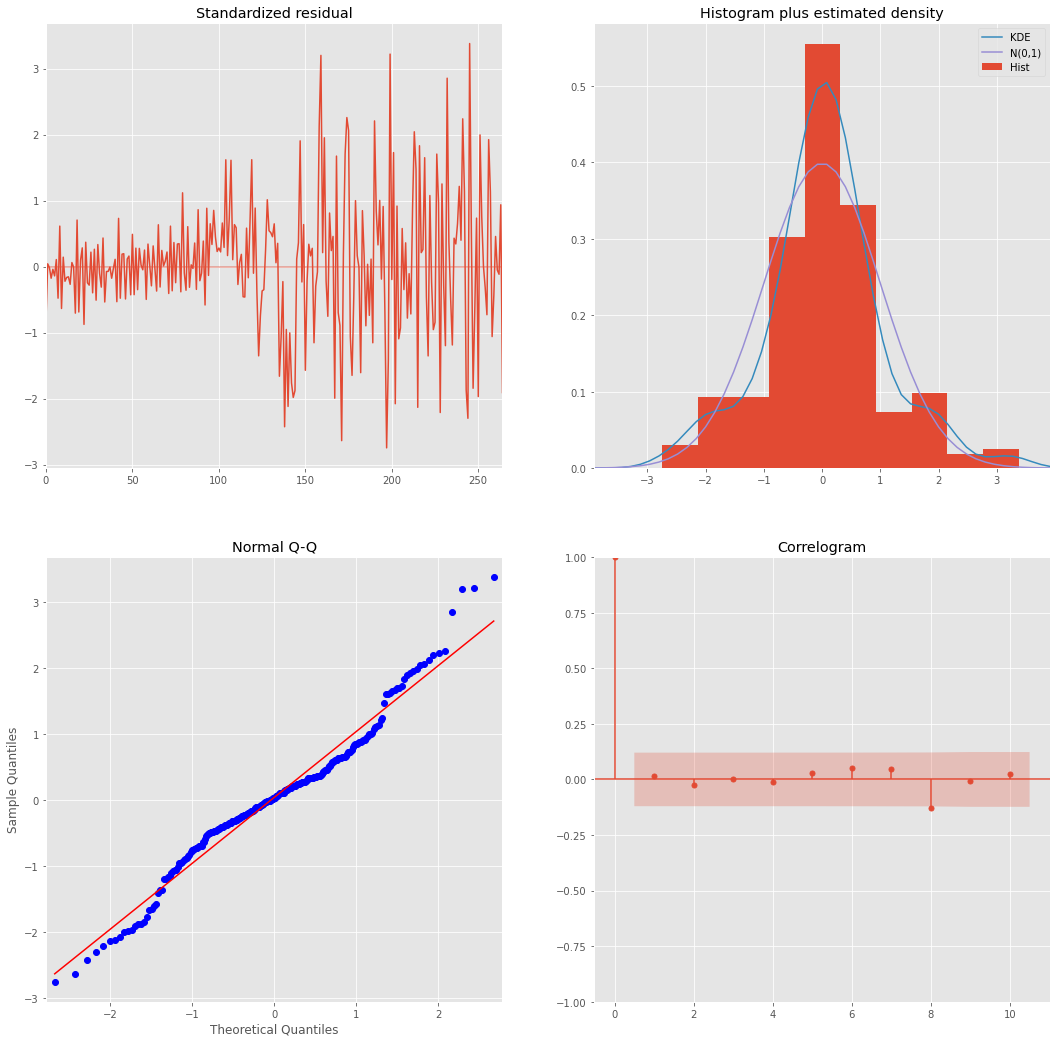

In [54]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series33126, 
                                        order=(2,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

We want to ensure that our residuals are uncorrelated, normally distributed and have zero mean. If not, we need to tweak our model further.

Let's check for these assumptions from diagnostics plots.

* Top-right plot - ????????????

* Our qq-plot shown on the bottom left displays that our residuals are somewhat following the linear trend line. This tells us that the residuals seen here are normally distributed.

* The autocorrelation plot on the bottom right, shows that the time series residuals have low correlation with lagged versions of itself.

????? These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [55]:
# Get predictions starting from 04-01-2015 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower value,upper value
2015-04-01,207766.216419,209727.890770
2015-05-01,208361.105727,210322.780078
2015-06-01,210529.132654,212490.807004
2015-07-01,212557.992920,214519.667270
2015-08-01,213126.839267,215088.513617
2015-09-01,216773.288532,218734.962882
2015-10-01,221219.744601,223181.418951
2015-11-01,223972.143868,225933.818218
2015-12-01,224289.775400,226251.449750
2016-01-01,226542.755981,228504.430332


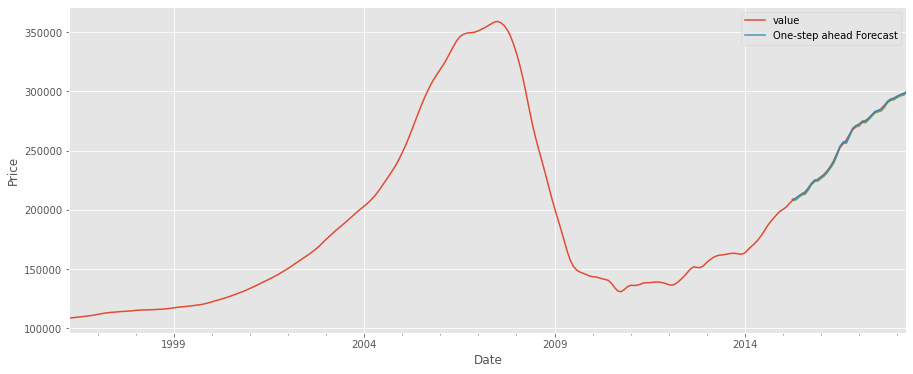

In [56]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = series33126.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [57]:
## Getting a forecast
forecast = output.get_forecast(36)
prediction = forecast.conf_int()
prediction['value'] = forecast.predicted_mean
prediction.columns = ['lower','upper','prediction'] 
prediction

,lower,upper,prediction
2018-05-01,297620.547118,299582.221468,298601.384293
2018-06-01,294995.437999,301058.743683,298027.090841
2018-07-01,291495.266039,303274.404653,297384.835346
2018-08-01,287449.889624,305997.945069,296723.917347
2018-09-01,283007.302747,309083.594772,296045.448759
2018-10-01,278255.358050,312445.612700,295350.485375
2018-11-01,273256.202432,316023.856892,294640.029662
2018-12-01,268057.274692,319772.792167,293915.033430
2019-01-01,262696.346931,323656.453788,293176.400359
2019-02-01,257204.312996,327645.663816,292424.988406


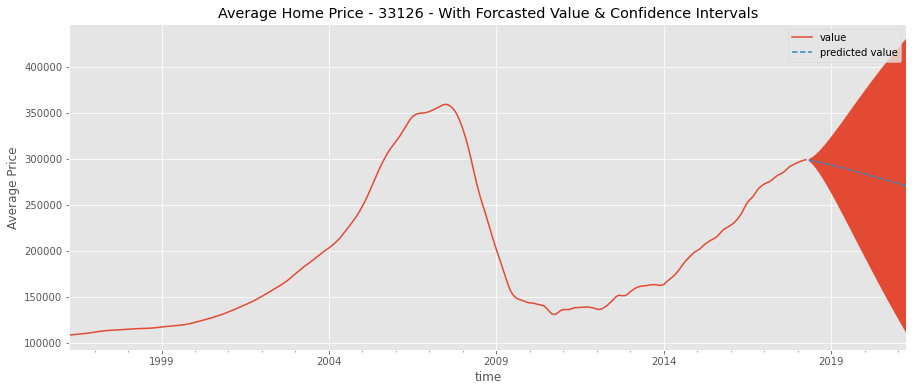

In [58]:
fig, ax = plt.subplots()
series33126.plot(ax=ax,label='values')


prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= prediction.index, y1= prediction['lower'], y2= prediction['upper'])
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33126 - With Forcasted Value & Confidence Intervals')
plt.show()

# Modeling every Zip Code in Florida

In [59]:
#List of Zip Codes in the Miami-Fort Lauderdale metro region.
miami_budget_zips = [a for a in miami_budget['RegionName']]

In [54]:
len(miami_budget_zips)

16

In [ ]:
zip_predictions = {}

for zipcode in miami_budget_zips:
    
    series = melt_data(df[df['RegionName']== zipcode])
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
    
    #Finding the combination of parameters with the smallest AIC value.
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    results = dict(ans_df.loc[ans_df['aic'].idxmin()])

    # Plug the optimal parameter values into a new SARIMAX model
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series, 
                                            order= results['pdq'], 
                                            seasonal_order= results['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    # Get predictions starting from and calculate confidence intervals
    pred = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
    pred_conf = pred.conf_int()

    ## Getting a forecast
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    zip_predictions[zipcode]= prediction['prediction']




In [ ]:
forecast_3yr = {}
for a in miami_metro_zips:
    forecast_3yr[a] = zip_predictions[a]['2021-04-01']

In [ ]:
# 3 year forecast for zipcodes
sort_orders = sorted(forecast_3yr.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

In [ ]:
# 3 year forecast for zipcodes arranged in descending order
sorted_forecast_3yr

In [ ]:
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

In [ ]:
top_5_zipcodes